# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [12]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models
from tensorflow.contrib.keras.python.keras.callbacks import ModelCheckpoint


from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # This layer preserves the input layer dimension by using a stride of 1.
    input_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=1,
                             padding='same', activation='relu')(input_layer)

    output_layer = separable_conv2d_batchnorm(input_layer=input_layer, filters=filters,                             strides=strides)        

    return output_layer
    

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # Upsample the input from previous layer    
    upsample_layer = bilinear_upsample(small_ip_layer)
    
    # Concat the upsampled layer with an earlier layer.
    concat_layer = layers.concatenate(inputs=[upsample_layer, large_ip_layer])
    
    # Convolution on the concatenated layer
    output_layer = separable_conv2d_batchnorm(input_layer=concat_layer, filters=filters)
        
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    l1 = encoder_block(inputs, filters=8, strides=2)        #(?, 128, 128, 8)
    l2 = encoder_block(l1, filters=16, strides=2)           #(?, 64, 64, 16)
    l3 = encoder_block(l2, filters=32, strides=2)           #(?, 32, 32, 32)
    l3_2 = encoder_block(l3, filters=64, strides=2)         #(?, 16, 16, 64)
    l3_3 = encoder_block(l3_2, filters=128, strides=2)      #(?, 8, 8, 128)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    l4 = conv2d_batchnorm(l3_3, filters=256, kernel_size=1) #(?, 8, 8, 256)
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    l5_3 = decoder_block(l4, l3_2, filters=128)             #(?, 16, 16, 128)
    l5_2 = decoder_block(l5_3, l3, filters=64)              #(?, 32, 32, 64)
    l5 = decoder_block(l5_2, l2, filters=32)                #(?, 64, 64, 32)
    l6 = decoder_block(l5, l1, filters=16)                  #(?, 128, 128, 16)
    l7 = decoder_block(l6, inputs, filters=8)               #(?, 256, 256, 8)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    output_layer = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(l7)
    return output_layer

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 256
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [10]:
learning_rate = 0.001
batch_size = 32
num_epochs = 50
steps_per_epoch = 258
validation_steps = 100
workers = 2

Epoch 1/50
257/258 [============================>.] - ETA: 1s - loss: 0.0391

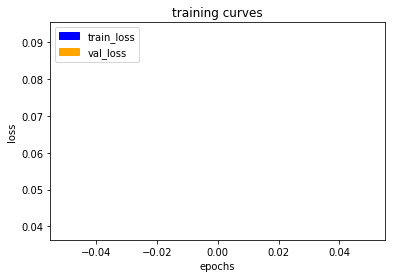

Epoch 00000: saving model to ../data/weights/unet_00_0.039_0.093
258/258 [==============================] - 283s - loss: 0.0390 - val_loss: 0.0927
Epoch 2/50
257/258 [============================>.] - ETA: 1s - loss: 0.0301

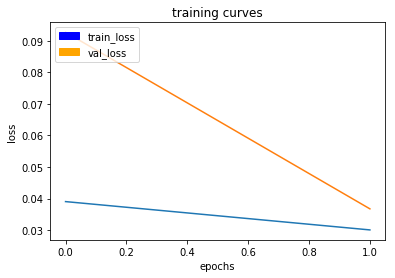

Epoch 00001: saving model to ../data/weights/unet_01_0.030_0.037
258/258 [==============================] - 273s - loss: 0.0301 - val_loss: 0.0367
Epoch 3/50
257/258 [============================>.] - ETA: 1s - loss: 0.0263

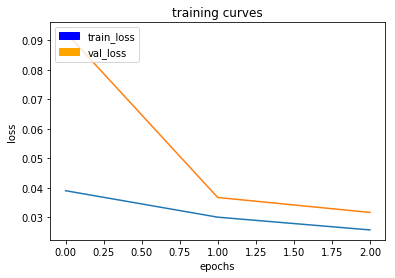

Epoch 00002: saving model to ../data/weights/unet_02_0.026_0.032
258/258 [==============================] - 272s - loss: 0.0263 - val_loss: 0.0317
Epoch 4/50
257/258 [============================>.] - ETA: 1s - loss: 0.0224

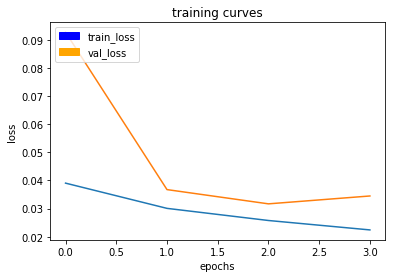

Epoch 00003: saving model to ../data/weights/unet_03_0.022_0.034
258/258 [==============================] - 271s - loss: 0.0224 - val_loss: 0.0345
Epoch 5/50
257/258 [============================>.] - ETA: 1s - loss: 0.0196

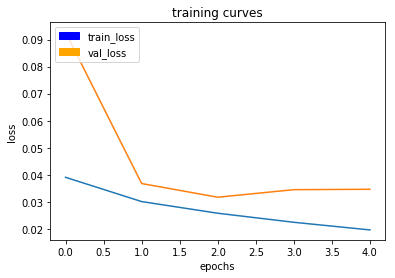

Epoch 00004: saving model to ../data/weights/unet_04_0.020_0.035
258/258 [==============================] - 272s - loss: 0.0196 - val_loss: 0.0346
Epoch 6/50
257/258 [============================>.] - ETA: 1s - loss: 0.0207

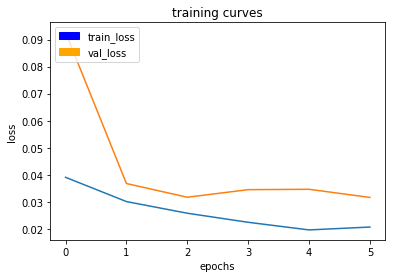

Epoch 00005: saving model to ../data/weights/unet_05_0.021_0.032
258/258 [==============================] - 271s - loss: 0.0207 - val_loss: 0.0316
Epoch 7/50
257/258 [============================>.] - ETA: 1s - loss: 0.0172

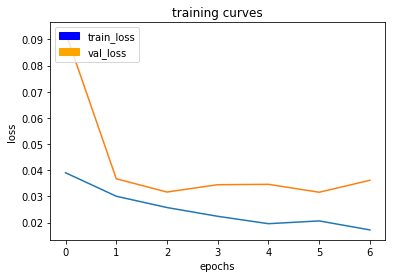

Epoch 00006: saving model to ../data/weights/unet_06_0.017_0.036
258/258 [==============================] - 271s - loss: 0.0172 - val_loss: 0.0362
Epoch 8/50
257/258 [============================>.] - ETA: 1s - loss: 0.0181

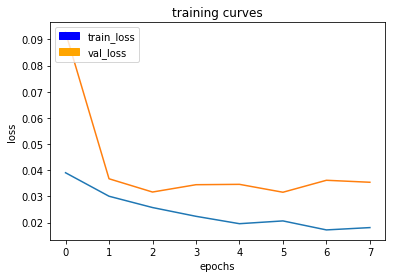

Epoch 00007: saving model to ../data/weights/unet_07_0.018_0.035
258/258 [==============================] - 271s - loss: 0.0181 - val_loss: 0.0354
Epoch 9/50
257/258 [============================>.] - ETA: 1s - loss: 0.0154

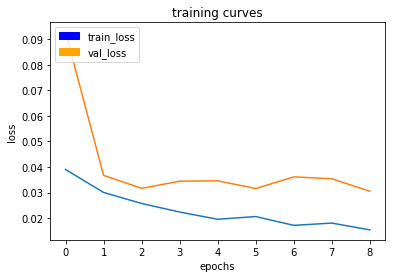

Epoch 00008: saving model to ../data/weights/unet_08_0.015_0.031
258/258 [==============================] - 271s - loss: 0.0154 - val_loss: 0.0305
Epoch 10/50
257/258 [============================>.] - ETA: 1s - loss: 0.0143

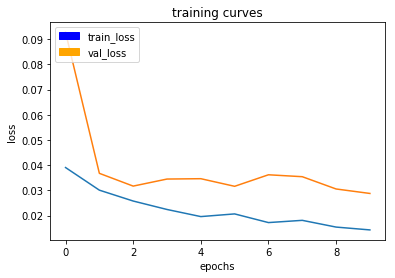

Epoch 00009: saving model to ../data/weights/unet_09_0.014_0.029
258/258 [==============================] - 271s - loss: 0.0143 - val_loss: 0.0288
Epoch 11/50
257/258 [============================>.] - ETA: 1s - loss: 0.0150

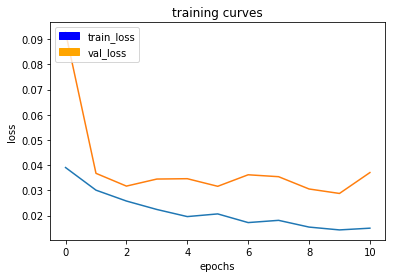

Epoch 00010: saving model to ../data/weights/unet_10_0.015_0.037
258/258 [==============================] - 271s - loss: 0.0149 - val_loss: 0.0370
Epoch 12/50
257/258 [============================>.] - ETA: 1s - loss: 0.0142

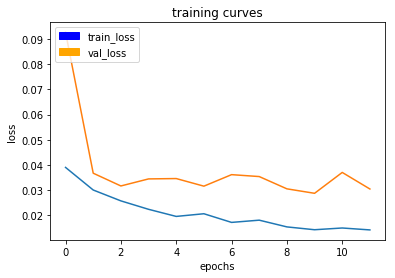

Epoch 00011: saving model to ../data/weights/unet_11_0.014_0.030
258/258 [==============================] - 271s - loss: 0.0142 - val_loss: 0.0305
Epoch 13/50
257/258 [============================>.] - ETA: 1s - loss: 0.0131

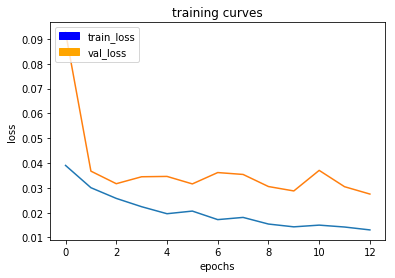

Epoch 00012: saving model to ../data/weights/unet_12_0.013_0.027
258/258 [==============================] - 270s - loss: 0.0131 - val_loss: 0.0275
Epoch 14/50
257/258 [============================>.] - ETA: 1s - loss: 0.0121

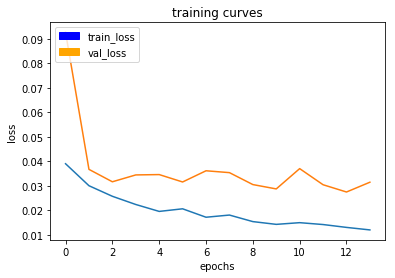

Epoch 00013: saving model to ../data/weights/unet_13_0.012_0.031
258/258 [==============================] - 270s - loss: 0.0121 - val_loss: 0.0315
Epoch 15/50
257/258 [============================>.] - ETA: 1s - loss: 0.0150

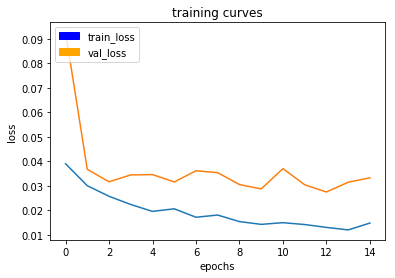

Epoch 00014: saving model to ../data/weights/unet_14_0.015_0.033
258/258 [==============================] - 271s - loss: 0.0150 - val_loss: 0.0333
Epoch 16/50
257/258 [============================>.] - ETA: 1s - loss: 0.0124

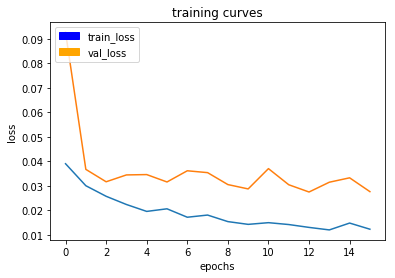

Epoch 00015: saving model to ../data/weights/unet_15_0.012_0.028
258/258 [==============================] - 276s - loss: 0.0124 - val_loss: 0.0276
Epoch 17/50
257/258 [============================>.] - ETA: 1s - loss: 0.0112

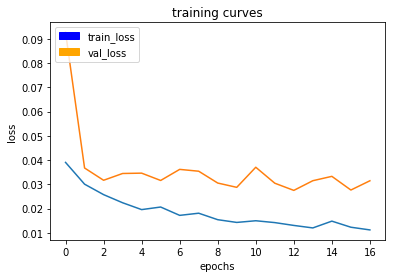

Epoch 00016: saving model to ../data/weights/unet_16_0.011_0.031
258/258 [==============================] - 271s - loss: 0.0112 - val_loss: 0.0315
Epoch 18/50
257/258 [============================>.] - ETA: 1s - loss: 0.0115

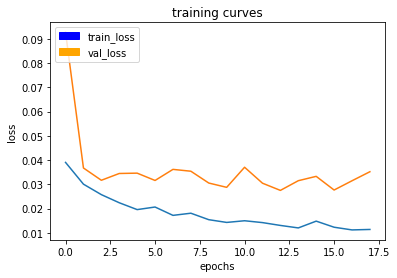

Epoch 00017: saving model to ../data/weights/unet_17_0.011_0.035
258/258 [==============================] - 270s - loss: 0.0115 - val_loss: 0.0352
Epoch 19/50
257/258 [============================>.] - ETA: 1s - loss: 0.0126

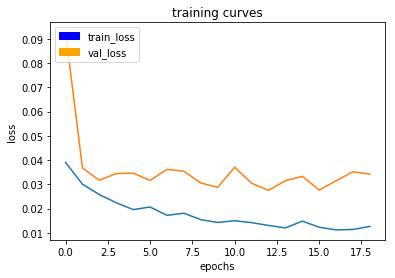

Epoch 00018: saving model to ../data/weights/unet_18_0.013_0.034
258/258 [==============================] - 271s - loss: 0.0127 - val_loss: 0.0342
Epoch 20/50
257/258 [============================>.] - ETA: 1s - loss: 0.0109

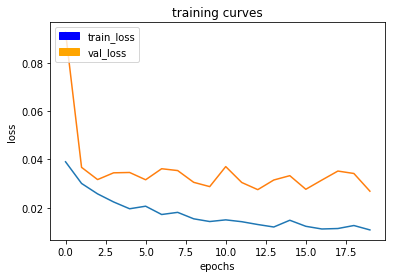

Epoch 00019: saving model to ../data/weights/unet_19_0.011_0.027
258/258 [==============================] - 271s - loss: 0.0109 - val_loss: 0.0269
Epoch 21/50
257/258 [============================>.] - ETA: 1s - loss: 0.0116

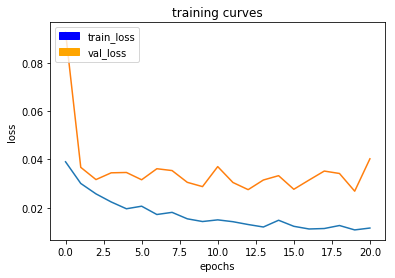

Epoch 00020: saving model to ../data/weights/unet_20_0.012_0.040
258/258 [==============================] - 270s - loss: 0.0116 - val_loss: 0.0403
Epoch 22/50
257/258 [============================>.] - ETA: 1s - loss: 0.0115

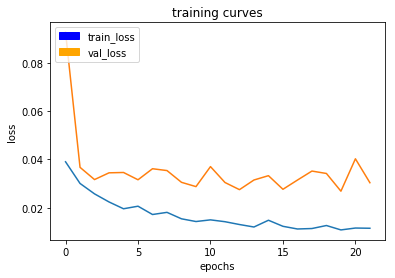

Epoch 00021: saving model to ../data/weights/unet_21_0.011_0.030
258/258 [==============================] - 271s - loss: 0.0115 - val_loss: 0.0304
Epoch 23/50
257/258 [============================>.] - ETA: 1s - loss: 0.0099

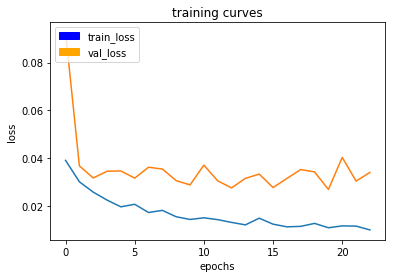

Epoch 00022: saving model to ../data/weights/unet_22_0.010_0.034
258/258 [==============================] - 271s - loss: 0.0099 - val_loss: 0.0340
Epoch 24/50
257/258 [============================>.] - ETA: 1s - loss: 0.0092

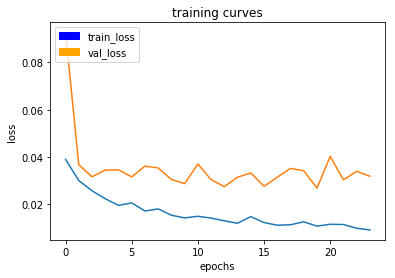

Epoch 00023: saving model to ../data/weights/unet_23_0.009_0.032
258/258 [==============================] - 270s - loss: 0.0092 - val_loss: 0.0319
Epoch 25/50
257/258 [============================>.] - ETA: 1s - loss: 0.0091

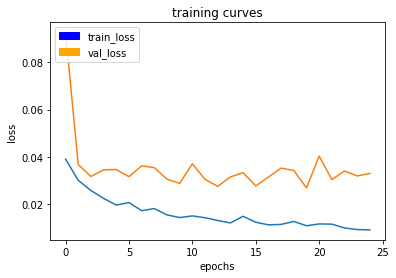

Epoch 00024: saving model to ../data/weights/unet_24_0.009_0.033
258/258 [==============================] - 271s - loss: 0.0090 - val_loss: 0.0330
Epoch 26/50
257/258 [============================>.] - ETA: 1s - loss: 0.0095

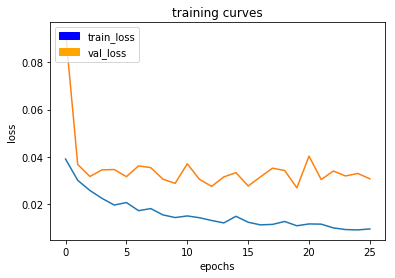

Epoch 00025: saving model to ../data/weights/unet_25_0.009_0.031
258/258 [==============================] - 270s - loss: 0.0095 - val_loss: 0.0307
Epoch 27/50
257/258 [============================>.] - ETA: 1s - loss: 0.0116

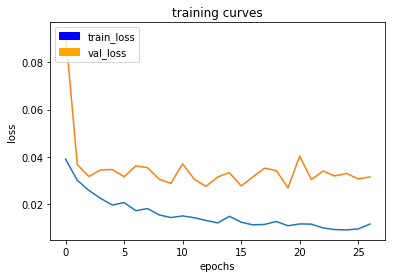

Epoch 00026: saving model to ../data/weights/unet_26_0.012_0.031
258/258 [==============================] - 270s - loss: 0.0116 - val_loss: 0.0315
Epoch 28/50
257/258 [============================>.] - ETA: 1s - loss: 0.0094

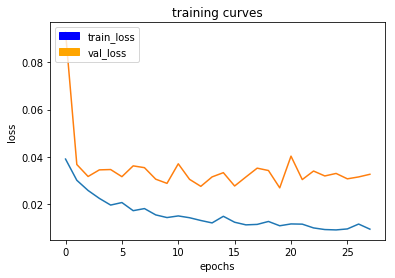

Epoch 00027: saving model to ../data/weights/unet_27_0.009_0.033
258/258 [==============================] - 271s - loss: 0.0094 - val_loss: 0.0326
Epoch 29/50
257/258 [============================>.] - ETA: 1s - loss: 0.0088

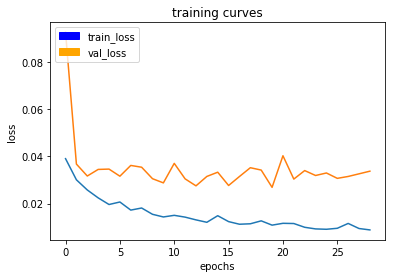

Epoch 00028: saving model to ../data/weights/unet_28_0.009_0.034
258/258 [==============================] - 278s - loss: 0.0088 - val_loss: 0.0337
Epoch 30/50
257/258 [============================>.] - ETA: 1s - loss: 0.0106

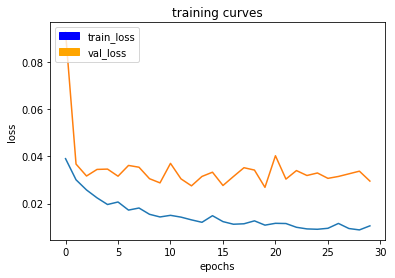

Epoch 00029: saving model to ../data/weights/unet_29_0.011_0.030
258/258 [==============================] - 288s - loss: 0.0106 - val_loss: 0.0295
Epoch 31/50
257/258 [============================>.] - ETA: 1s - loss: 0.0088

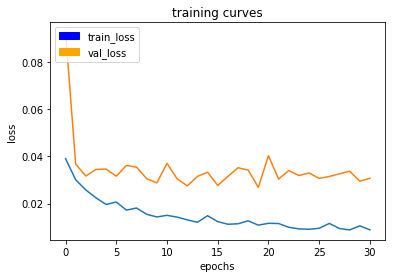

Epoch 00030: saving model to ../data/weights/unet_30_0.009_0.031
258/258 [==============================] - 280s - loss: 0.0088 - val_loss: 0.0307
Epoch 32/50
257/258 [============================>.] - ETA: 1s - loss: 0.0085

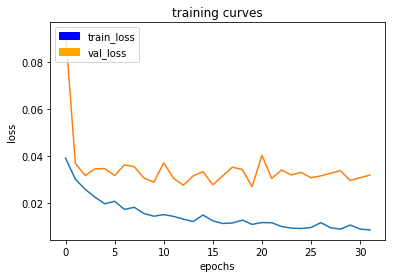

Epoch 00031: saving model to ../data/weights/unet_31_0.008_0.032
258/258 [==============================] - 278s - loss: 0.0085 - val_loss: 0.0318
Epoch 33/50
257/258 [============================>.] - ETA: 1s - loss: 0.0095

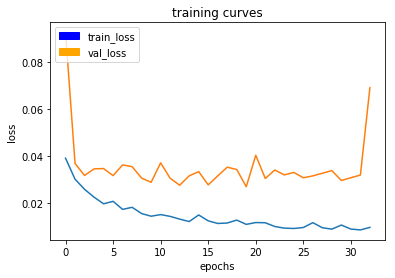

Epoch 00032: saving model to ../data/weights/unet_32_0.010_0.069
258/258 [==============================] - 284s - loss: 0.0096 - val_loss: 0.0691
Epoch 34/50
257/258 [============================>.] - ETA: 1s - loss: 0.0127

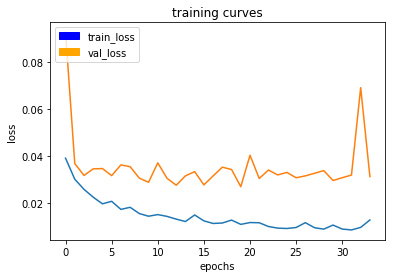

Epoch 00033: saving model to ../data/weights/unet_33_0.013_0.031
258/258 [==============================] - 269s - loss: 0.0127 - val_loss: 0.0312
Epoch 35/50
257/258 [============================>.] - ETA: 1s - loss: 0.0089

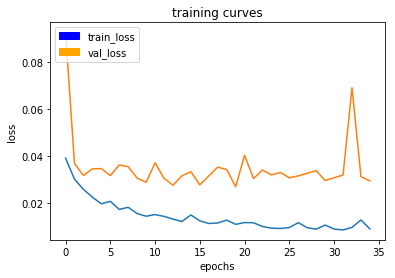

Epoch 00034: saving model to ../data/weights/unet_34_0.009_0.029
258/258 [==============================] - 269s - loss: 0.0089 - val_loss: 0.0293
Epoch 36/50
257/258 [============================>.] - ETA: 1s - loss: 0.0081

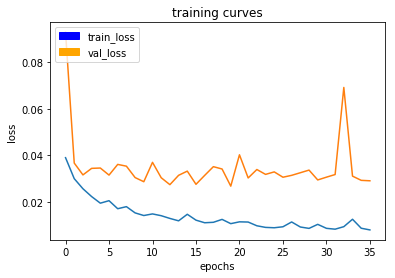

Epoch 00035: saving model to ../data/weights/unet_35_0.008_0.029
258/258 [==============================] - 269s - loss: 0.0081 - val_loss: 0.0292
Epoch 37/50
257/258 [============================>.] - ETA: 1s - loss: 0.0079

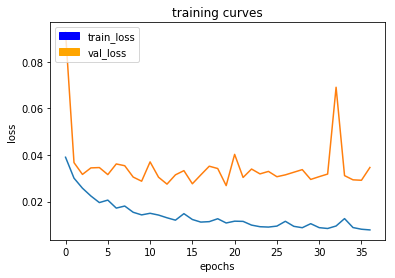

Epoch 00036: saving model to ../data/weights/unet_36_0.008_0.035
258/258 [==============================] - 269s - loss: 0.0079 - val_loss: 0.0346
Epoch 38/50
257/258 [============================>.] - ETA: 1s - loss: 0.0076

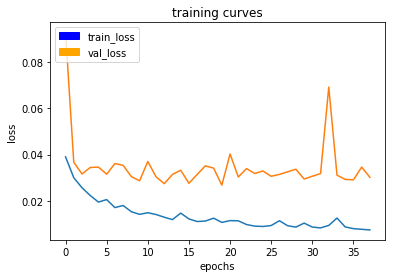

Epoch 00037: saving model to ../data/weights/unet_37_0.008_0.030
258/258 [==============================] - 269s - loss: 0.0076 - val_loss: 0.0302
Epoch 39/50
257/258 [============================>.] - ETA: 1s - loss: 0.0075

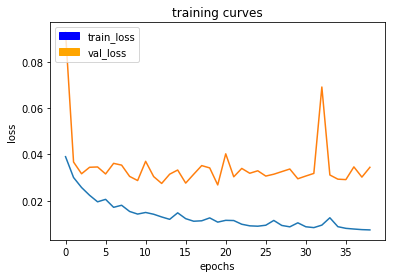

Epoch 00038: saving model to ../data/weights/unet_38_0.007_0.034
258/258 [==============================] - 269s - loss: 0.0075 - val_loss: 0.0345
Epoch 40/50
257/258 [============================>.] - ETA: 1s - loss: 0.0074

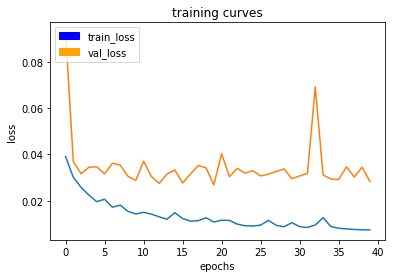

Epoch 00039: saving model to ../data/weights/unet_39_0.007_0.028
258/258 [==============================] - 268s - loss: 0.0074 - val_loss: 0.0283
Epoch 41/50
257/258 [============================>.] - ETA: 1s - loss: 0.0073

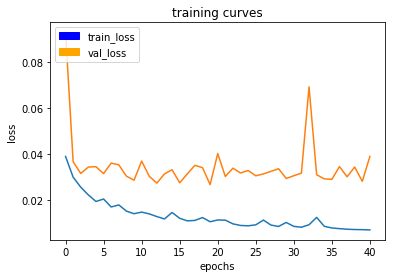

Epoch 00040: saving model to ../data/weights/unet_40_0.007_0.039
258/258 [==============================] - 269s - loss: 0.0073 - val_loss: 0.0391
Epoch 42/50
257/258 [============================>.] - ETA: 1s - loss: 0.0072

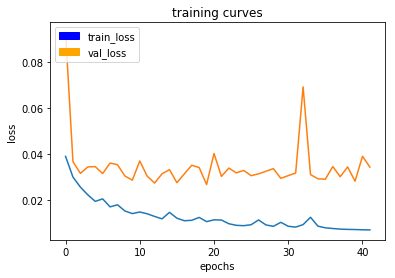

Epoch 00041: saving model to ../data/weights/unet_41_0.007_0.034
258/258 [==============================] - 268s - loss: 0.0073 - val_loss: 0.0344
Epoch 43/50
257/258 [============================>.] - ETA: 1s - loss: 0.0109

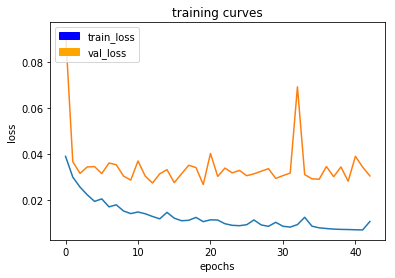

Epoch 00042: saving model to ../data/weights/unet_42_0.011_0.031
258/258 [==============================] - 268s - loss: 0.0109 - val_loss: 0.0306
Epoch 44/50
257/258 [============================>.] - ETA: 1s - loss: 0.0090

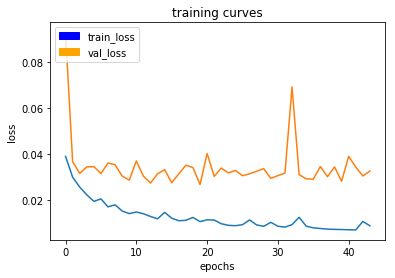

Epoch 00043: saving model to ../data/weights/unet_43_0.009_0.033
258/258 [==============================] - 268s - loss: 0.0090 - val_loss: 0.0327
Epoch 45/50
257/258 [============================>.] - ETA: 1s - loss: 0.0077

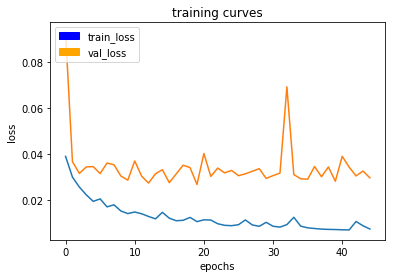

Epoch 00044: saving model to ../data/weights/unet_44_0.008_0.030
258/258 [==============================] - 268s - loss: 0.0077 - val_loss: 0.0297
Epoch 46/50
257/258 [============================>.] - ETA: 1s - loss: 0.0073

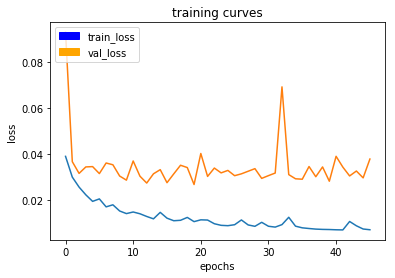

Epoch 00045: saving model to ../data/weights/unet_45_0.007_0.038
258/258 [==============================] - 268s - loss: 0.0074 - val_loss: 0.0379
Epoch 47/50
257/258 [============================>.] - ETA: 1s - loss: 0.0071

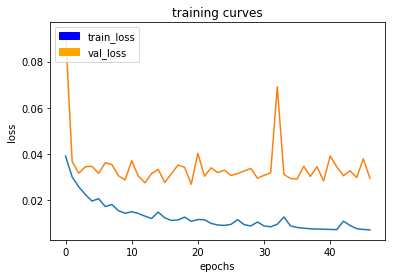

Epoch 00046: saving model to ../data/weights/unet_46_0.007_0.029
258/258 [==============================] - 268s - loss: 0.0071 - val_loss: 0.0295
Epoch 48/50
257/258 [============================>.] - ETA: 1s - loss: 0.0072

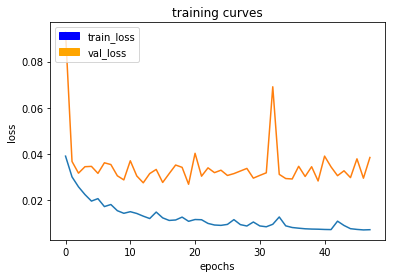

Epoch 00047: saving model to ../data/weights/unet_47_0.007_0.038
258/258 [==============================] - 268s - loss: 0.0072 - val_loss: 0.0385
Epoch 49/50
257/258 [============================>.] - ETA: 1s - loss: 0.0070

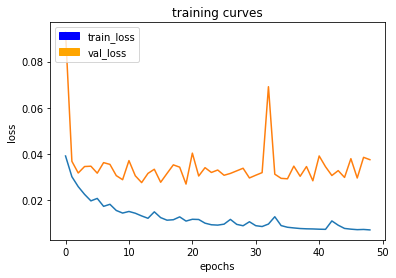

Epoch 00048: saving model to ../data/weights/unet_48_0.007_0.037
258/258 [==============================] - 270s - loss: 0.0070 - val_loss: 0.0374
Epoch 50/50
257/258 [============================>.] - ETA: 1s - loss: 0.0067

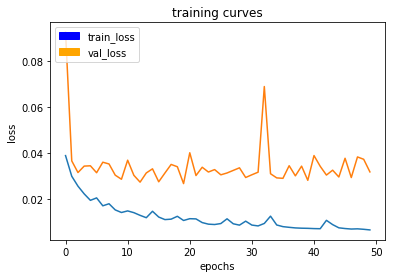

Epoch 00049: saving model to ../data/weights/unet_49_0.007_0.032
258/258 [==============================] - 268s - loss: 0.0067 - val_loss: 0.0320


In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]
callbacks.append(ModelCheckpoint(filepath='../data/weights/unet_{epoch:02d}_{loss:.3f}_{val_loss:.3f}',
                             monitor = 'val_loss', verbose=1, save_best_only=False, save_weights_only=True))

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [ ]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [ ]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [16]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

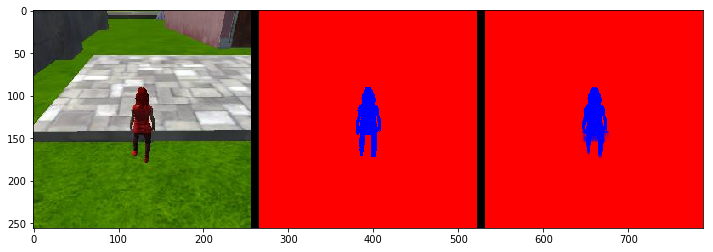

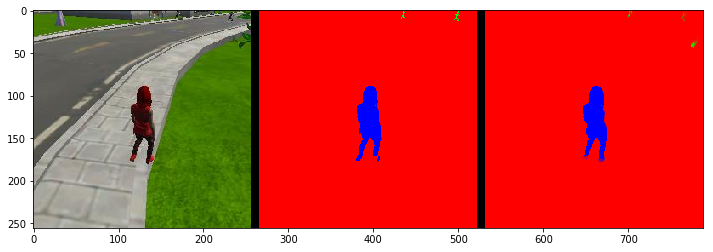

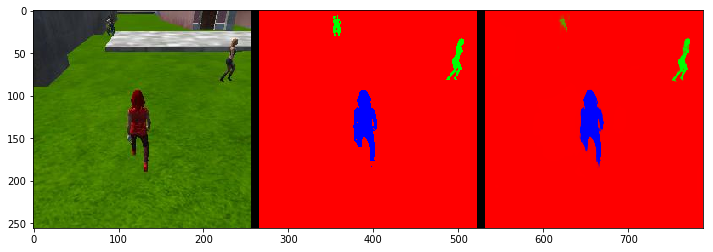

In [17]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

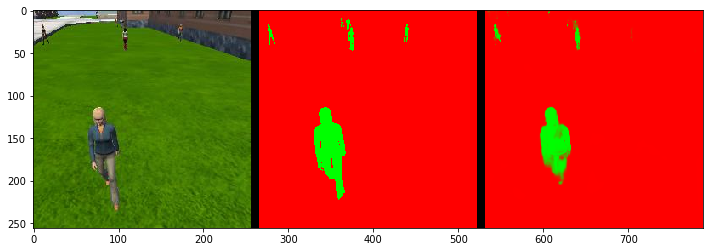

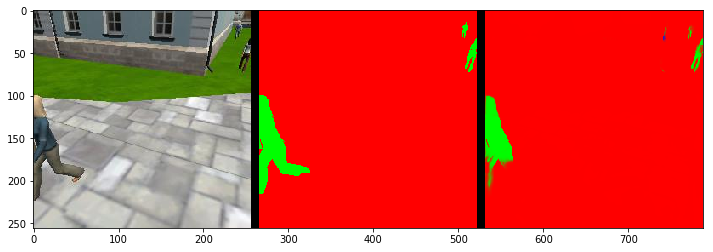

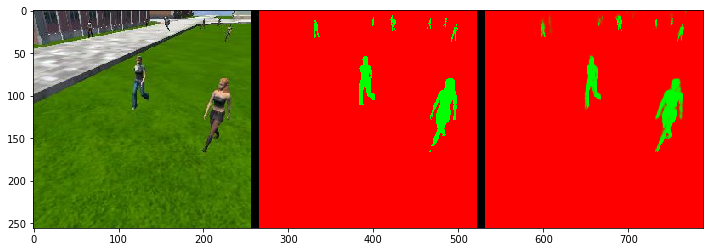

In [18]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

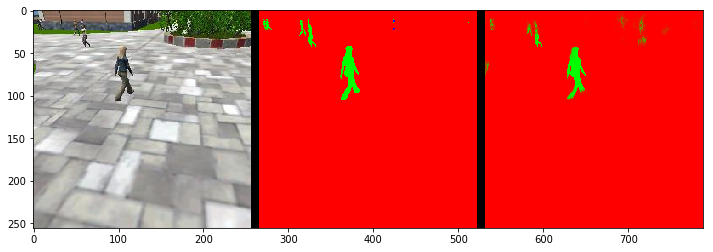

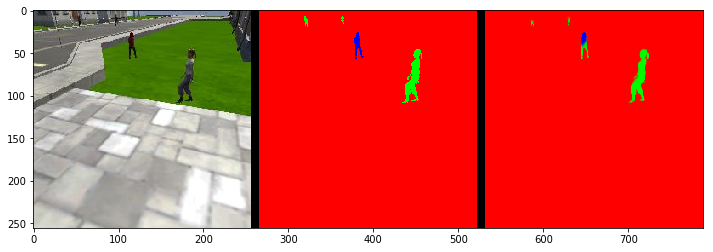

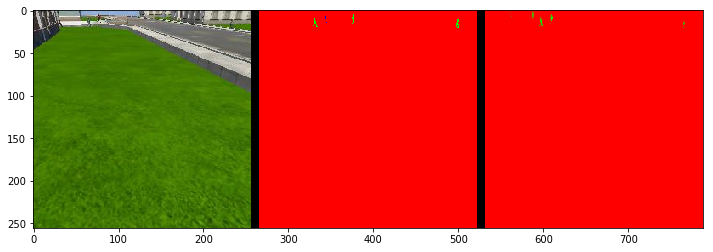

In [19]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [20]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9963938662777779
average intersection over union for other people is 0.3944458773548556
average intersection over union for the hero is 0.9413495991541102
number true positives: 539, number false positives: 0, number false negatives: 0


In [21]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9883471871708678
average intersection over union for other people is 0.7761354647847789
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 37, number false negatives: 0


In [22]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9969518084889623
average intersection over union for other people is 0.4792195755153399
average intersection over union for the hero is 0.2115566470572248
number true positives: 130, number false positives: 1, number false negatives: 182


In [23]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7525309336332958


In [24]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.576453123106


In [25]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.433798806927
